<a href="https://colab.research.google.com/github/Ofir-Manor/Long3/blob/main/316084623-311288203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> HW3 Major</h1>
<h1 align="center"> Regression</h1>

>[Section 0](#scrollTo=PP97jnMOwhsc)

>>[Setting the Environment](#scrollTo=PcPDtRW0CBbT)

>>[Preliminary: Updated Data Loading](#scrollTo=WIJ3zdABCFSv)

>[Section 1: Linear regression implementation](#scrollTo=B_lm9iUdwaNN)

>>[Question 2](#scrollTo=yZfgNt9Jf1mt)

>>[Question 3](#scrollTo=wXZOgxa-f1mv)

>[Section 2: Evaluation and Baseline](#scrollTo=-_pNB91uf1mw)

>>[Question 4](#scrollTo=zrD1pB21f1mw)

>>[Question 5](#scrollTo=p_Q5cc4Kf1mx)

>[Section 3: Linear Regressor with Lasso](#scrollTo=dSbdIwgvf1my)

>>[Question 7](#scrollTo=7R3R-3FBf1my)

>>[Question 8](#scrollTo=4wPReSIsf1my)

>>[Question 10](#scrollTo=sWcpMTzPf1mz)

>[Section 4: Polynomial fitting (visualization)](#scrollTo=CydyLBJdf1mz)

>>[Question 13](#scrollTo=Xth7lLu6f1m0)

>>[Question 14](#scrollTo=5hpOwrs-f1m0)

>>[Question 15](#scrollTo=Yuzri9Bef1m1)

>>[Question 16](#scrollTo=UovDm2uRf1m1)

>>[Question 17](#scrollTo=goNvykGhf1m1)

>>[Question 18](#scrollTo=UAV1fSfMf1m2)

>[Section 5: RandomForest fitting of the CovidScore](#scrollTo=bJI5M6Myf1m2)



# Section 0

## Setting the Environment

In [48]:
#@title Setting the Environment:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from typing import Union
params = {
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.titlesize' : 22,
    'axes.labelsize' : 20,
    'legend.fontsize': 18,
    'legend.title_fontsize': 22,
    'figure.titlesize': 24
 }
pylab.rcParams.update(params)

## Preliminary: Updated Data Loading

In [49]:
#@title Load the dataset, create DF and split it:

csv_url = 'https://raw.githubusercontent.com/Ofir-Manor/Long3/main/data/HW3_data.csv' # a link to the raw data

dataset = pd.DataFrame(pd.read_csv(csv_url))
from sklearn.model_selection import train_test_split
random_state = 3 + 23
train_raw, test_raw = train_test_split(dataset, test_size=0.2, random_state=random_state)

In [50]:
#@title Load the python code files and import them:

!pip install requests
import requests
scripts = {
    "prepare.py" : requests.get("https://raw.githubusercontent.com/Ofir-Manor/Long3/main/lib/prepare.py"),
    "LinearRegressor.py" : requests.get("https://raw.githubusercontent.com/Ofir-Manor/Long3/main/lib/LinearRegressor.py")
}
for name, script in scripts.items():
    with open(name, 'w') as f:
        f.write(script.text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
#@title Use `prepare_data` function:

from prepare import prepare_data
# Prepare training set according to itself
train = prepare_data(train_raw, train_raw)
# Prepare test set according to the raw training data
test = prepare_data(train_raw, test_raw)

# Section 1: Linear regression implementation

## Question 2

In [52]:
#@title Prep `Linear Regressor` training and validation set

from LinearRegressor import LinearRegressor
lin_reg_train, lin_reg_val = train_test_split(train, test_size=0.2, random_state=random_state)
lin_reg_train_x = lin_reg_train[lin_reg_train.columns.difference(["contamination_level"])]
lin_reg_train_y = lin_reg_train["contamination_level"]
lin_reg_val_x = lin_reg_val[lin_reg_val.columns.difference(["contamination_level"])]
lin_reg_val_y = lin_reg_val["contamination_level"]

In [53]:
#@title Copy of `verify_gradients.py` module:

def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

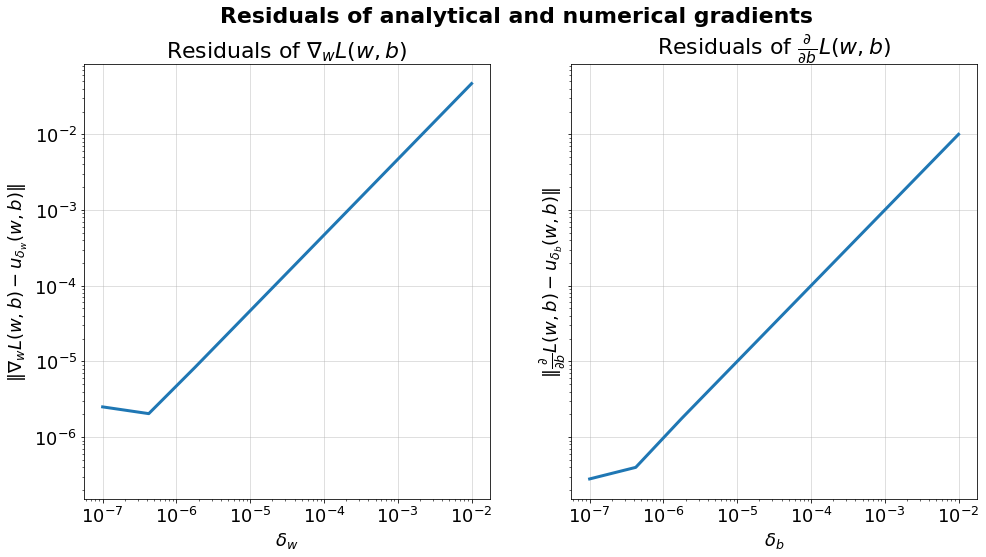

In [54]:
compare_gradients(lin_reg_train_x, lin_reg_train_y, deltas=np.logspace(-7, -2, 9))

## Question 3

In [55]:
#@title Copy of `test_lr.py` module:

import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 387.4981802595634, Best validation loss = 421.5168420204055
lr size = 1e-08, Best train loss = 387.4487131166349, Best validation loss = 421.4671246584343
lr size = 1e-07, Best train loss = 386.9545740122952, Best validation loss = 420.9704813270224
lr size = 1e-06, Best train loss = 382.0660211082413, Best validation loss = 416.0566864215049
lr size = 1e-05, Best train loss = 338.09119751217077, Best validation loss = 371.81312331068693
lr size = 0.0001, Best train loss = 159.55779983992582, Best validation loss = 190.8176714238625
lr size = 0.001, Best train loss = 97.34239765483836, Best validation loss = 128.17551760233803
lr size = 0.01, Best train loss = 90.77378254595253, Best validation loss = 117.01114805168662
lr size = 0.1, Best train loss = 93.25528699440298, Best validation loss = 117.4817515745496


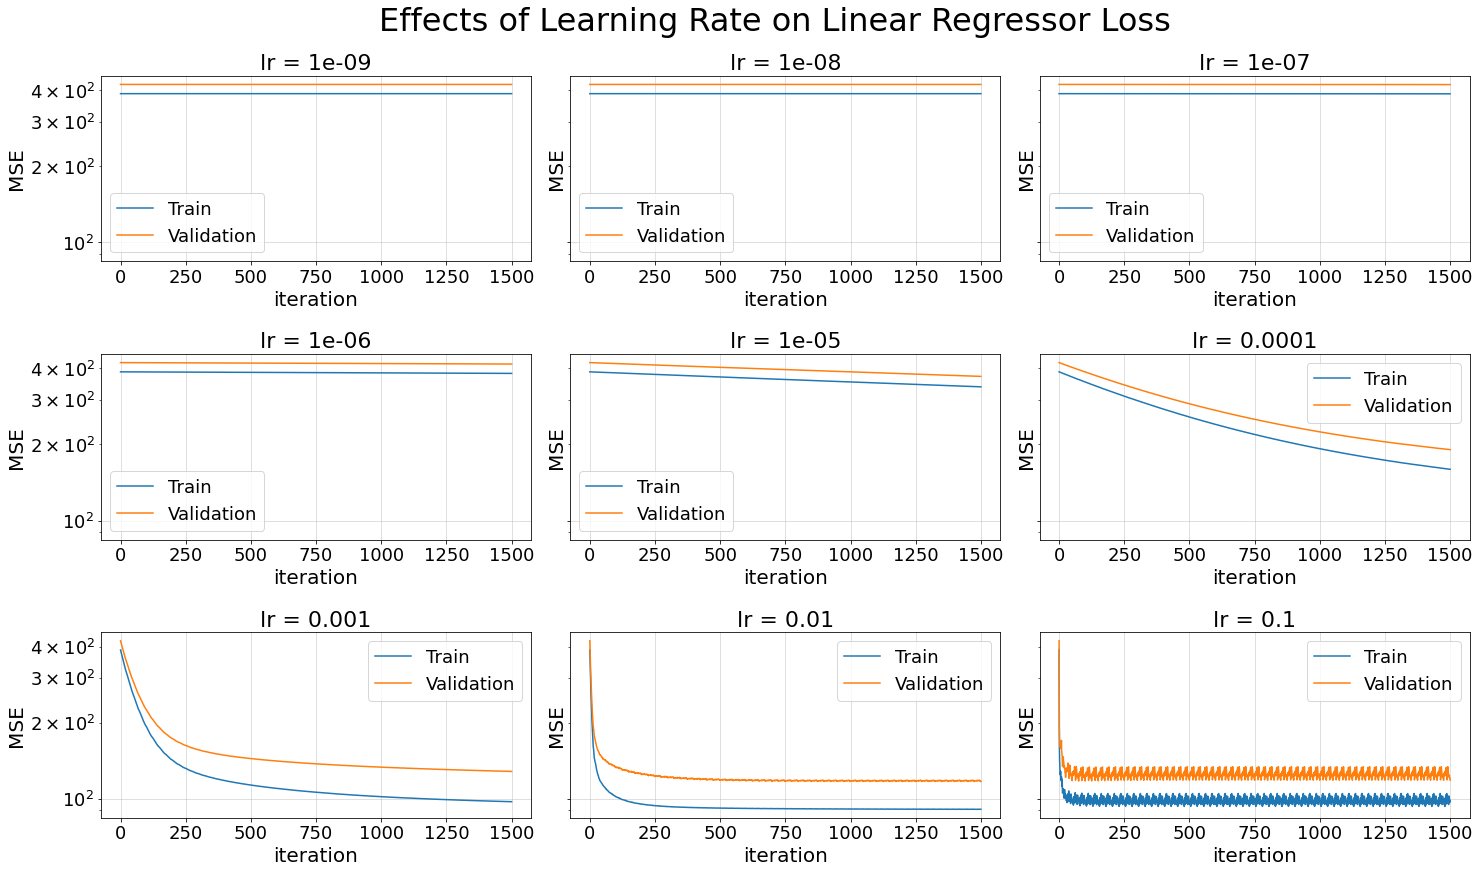

In [56]:
test_lr(lin_reg_train_x, lin_reg_train_y, lin_reg_val_x, lin_reg_val_y, title="Effects of Learning Rate on Linear Regressor Loss")



---



---



---



# Section 2: Evaluation and Baseline

## Question 4

In [57]:
#@title Dummy Regressor:

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

train_X = train.loc[:, train.columns != "contamination_level"]
train_y = train["contamination_level"]

dummy_regr = DummyRegressor(strategy="mean")

cv_dummy_regr_scores = cross_validate(dummy_regr,
                                      train_X, 
                                      train_y, 
                                      scoring="neg_mean_squared_error", 
                                      cv=5, 
                                      return_train_score=True)
print(f"The training MSE Scores are {cv_dummy_regr_scores['train_score']} and their average is {np.mean(cv_dummy_regr_scores['train_score'])}")
print(f"The validation MSE Scores are {cv_dummy_regr_scores['test_score']} and their average is {np.mean(cv_dummy_regr_scores['test_score'])}")

# For future purpose:
dummy_redr_train_loss = np.mean(cv_dummy_regr_scores['test_score'])
dummy_redr_val_loss = np.mean(cv_dummy_regr_scores['test_score'])

The training MSE Scores are [-105.14856234 -105.33416548 -105.85261118 -102.05445569 -110.72023985] and their average is -105.82200690688448
The validation MSE Scores are [-108.82678915 -107.96370075 -105.94952923 -121.1517169   -87.07070676] and their average is -106.19248855899191


In [58]:
dummy_regr.fit(train_X, train_y);

## Question 5

In [59]:
#@title Function to plot the scores for the CV process:

def semilogx_plot(hp_list, cv_train_score, cv_val_score, dummy_train_score, dummy_val_score, hp_title, model_title, figsize=(20, 12)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    plt.suptitle(f"Cross Vlaidation of {model_title} by {hp_title}", fontsize=32)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, wspace=0.2, top=0.9)
    axs = np.ravel(axs)
    
    axs[0].semilogx(hp_list, cv_train_score, label=model_title)
    axs[0].semilogx(hp_list, dummy_train_score, label="Dummy Regressor")
    axs[0].grid(alpha = 0.5)
    axs[0].legend()
    axs[0].set_title("Training")
    axs[0].set_xlabel(hp_title)
    axs[0].set_ylabel('MSE')
    
    axs[1].semilogx(hp_list, cv_val_score, label=model_title)
    axs[1].semilogx(hp_list, dummy_val_score, label="Dummy Regressor")
    axs[1].grid(alpha = 0.5)
    axs[1].legend()
    axs[1].set_title("Validation")
    axs[1].set_xlabel(hp_title)
    axs[1].set_ylabel('MSE')

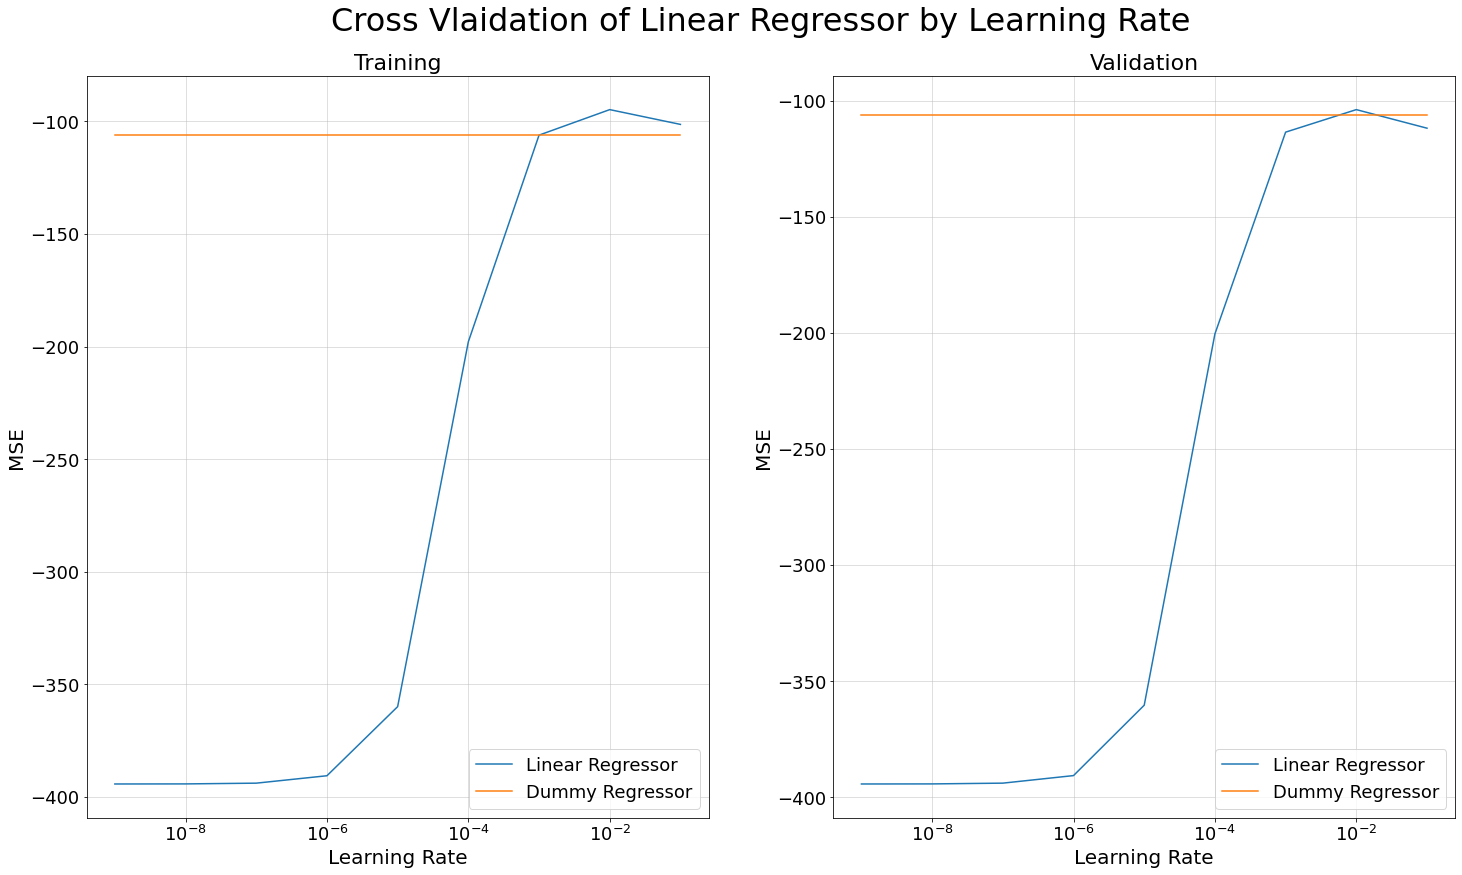

In [60]:
#@title Hyperparameter tuning:

lr_list = np.logspace(-9, -1, 9)
mean_train_score = []
mean_val_score = []

for lr in lr_list:
    cur_linear_reggressor = LinearRegressor(lr)
    cv_lin_regr_scores = cross_validate(cur_linear_reggressor,
                                        train_X,
                                        train_y, 
                                        scoring="neg_mean_squared_error", 
                                        cv=5, 
                                        return_train_score=True)
    mean_train_score = np.append(mean_train_score, np.mean(cv_lin_regr_scores['train_score']))
    mean_val_score = np.append(mean_val_score, np.mean(cv_lin_regr_scores['test_score']))

dummy_mean_train = np.full(shape=mean_train_score.shape, fill_value = dummy_redr_train_loss)
dummy_mean_val = np.full(shape=mean_val_score.shape, fill_value = dummy_redr_val_loss)

semilogx_plot(lr_list, 
              mean_train_score, 
              mean_val_score, 
              dummy_mean_train, 
              dummy_mean_val, 
              "Learning Rate", 
              "Linear Regressor")

In [61]:
#@title Optimal LR:

max_val_idx = np.argmax(mean_val_score)
print(f"The optimal learning rate is {lr_list[max_val_idx]} which achieved a training loss of {mean_train_score[max_val_idx]} and validation loss of {mean_val_score[max_val_idx]}")

The optimal learning rate is 0.01 which achieved a training loss of -94.77876756088422 and validation loss of -103.80760367787782


In [62]:
#@title Retain a Linear Regressor with the optimal LR:

linear_regressor = LinearRegressor(lr = lr_list[max_val_idx])
linear_regressor.fit(train_X, train_y);



---



---



---



# Section 3: Linear Regressor with Lasso

## Question 7

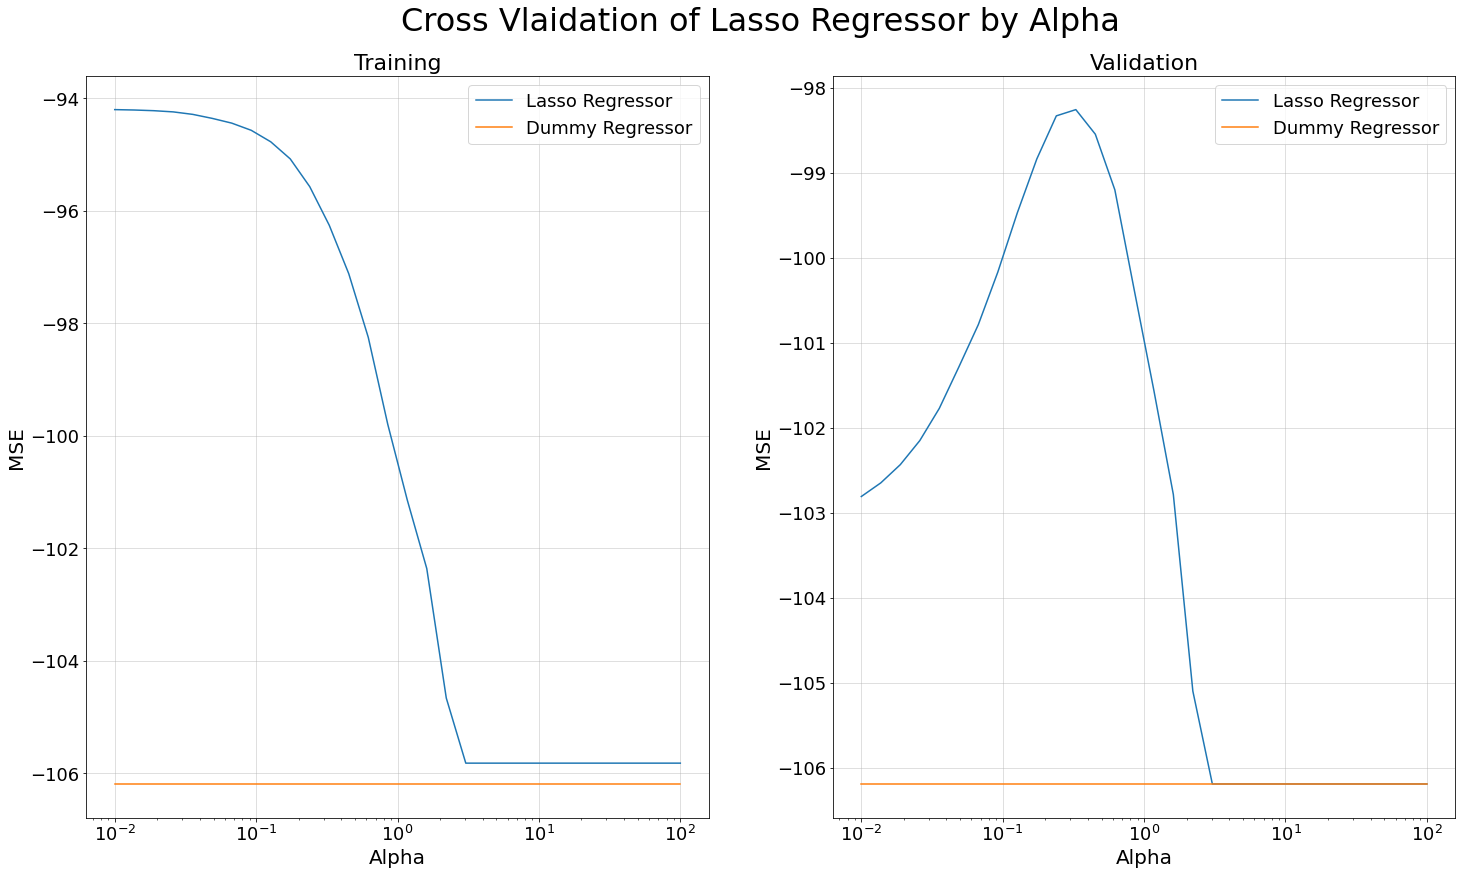

In [63]:
#@title Tune the regularization strength `alpha` of the regressor:

from sklearn.linear_model import Lasso

alpha_list = np.logspace(-2, 2, 30)
mean_train_score = []
mean_val_score = []

for alpha in alpha_list:
    cur_lasso = Lasso(alpha = alpha, fit_intercept=True)
    cv_lasso_scores = cross_validate(cur_lasso,
                                     train_X,
                                     train_y,
                                     scoring="neg_mean_squared_error",
                                     cv=5,
                                     return_train_score=True)
    mean_train_score = np.append(mean_train_score, np.mean(cv_lasso_scores['train_score']))
    mean_val_score = np.append(mean_val_score, np.mean(cv_lasso_scores['test_score']))

dummy_mean_train = np.full(shape=mean_train_score.shape, fill_value = dummy_redr_train_loss)
dummy_mean_val = np.full(shape=mean_val_score.shape, fill_value = dummy_redr_val_loss)

semilogx_plot(alpha_list, mean_train_score, mean_val_score, dummy_mean_train, dummy_mean_val, "Alpha", "Lasso Regressor")

## Question 8

In [64]:
#@title Get the optimal `alpha` and its score:

opt_alpha_idx = np.argmax(mean_val_score)
opt_alpha = alpha_list[opt_alpha_idx]
print(f"The optimal alpha is {opt_alpha} which achieved a training loss of {mean_train_score[opt_alpha_idx]} and a validation loss of {mean_val_score[opt_alpha_idx]}")

The optimal alpha is 0.32903445623126676 which achieved a training loss of -96.25793146139193 and a validation loss of -98.2546234390187


In [65]:
#@title Retain a Lasso Regressor with the optimal alpha:

lasso_regressor = Lasso(alpha = opt_alpha, fit_intercept=True)
lasso_regressor.fit(train_X, train_y);

## Question 9

In [66]:
#@title Specify the 5 features having the 5 largest coefficients (in absolute value) in the resulting regressor:

abs_coef = np.abs(lasso_regressor.coef_)
opt_coef_idx = np.flip(np.argsort(abs_coef))
print(f"The features with the largest (absolute) coefficient are: {train_X.columns[opt_coef_idx[:5]].values}.")
print(f"With the values: {abs_coef[opt_coef_idx][:5]}")

The features with the largest (absolute) coefficient are: ['sugar_levels' 'PCR_01' 'PCR_05' 'num_of_siblings' 'household_income'].
With the values: [2.12181816 1.87512749 0.37262854 0.36273336 0.17860567]


## Question 10

Text(0, 0.5, 'Feature Coefficient')

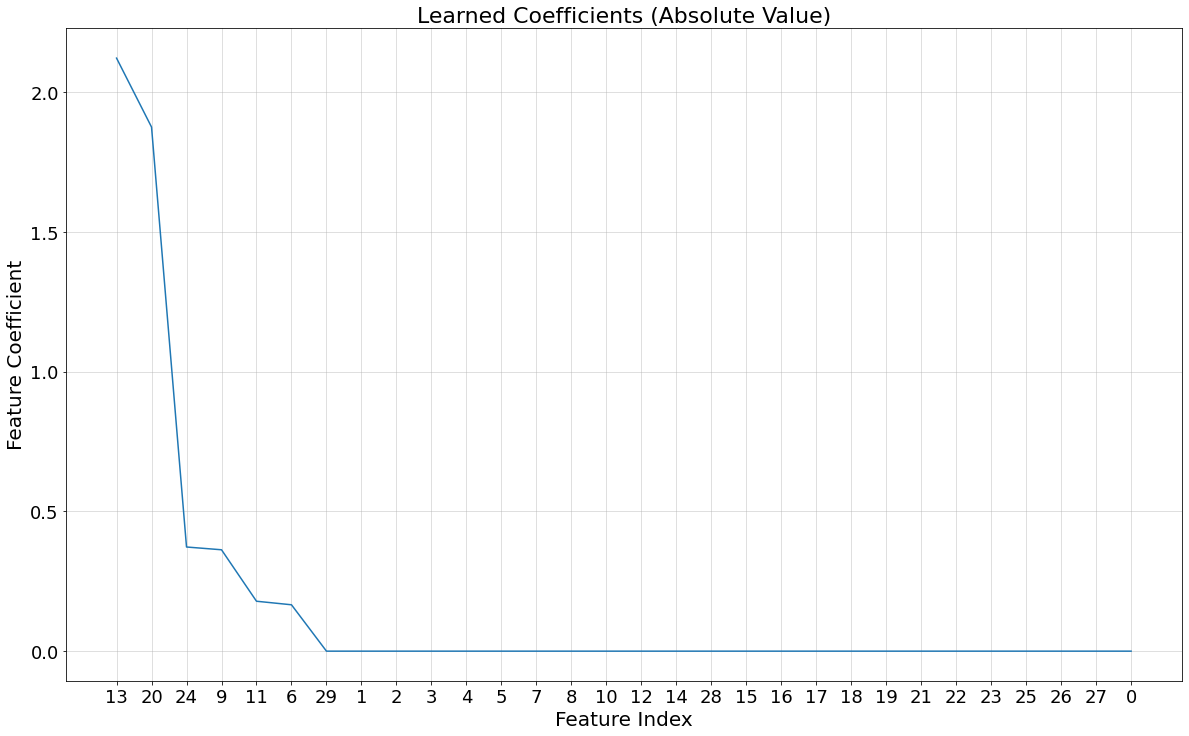

In [67]:
#@title Sort and plot the absolute values of the learned coefficients:

fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(abs_coef[opt_coef_idx])
plt.xticks(ticks = list(range(0, opt_coef_idx.size)),labels = opt_coef_idx)

ax.grid(alpha = 0.5)
ax.set_title("Learned Coefficients (Absolute Value)")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Feature Coefficient")



---



---



---



# Section 4: Polynomial fitting (visualization)

## Question 13

In [68]:
#@title Create a subset of the training set with these 2 features and contamination_level:

train_mod = train[["PCR_01", "PCR_05", "contamination_level"]]

In [69]:
#@title Definition of `plot3d`:

def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

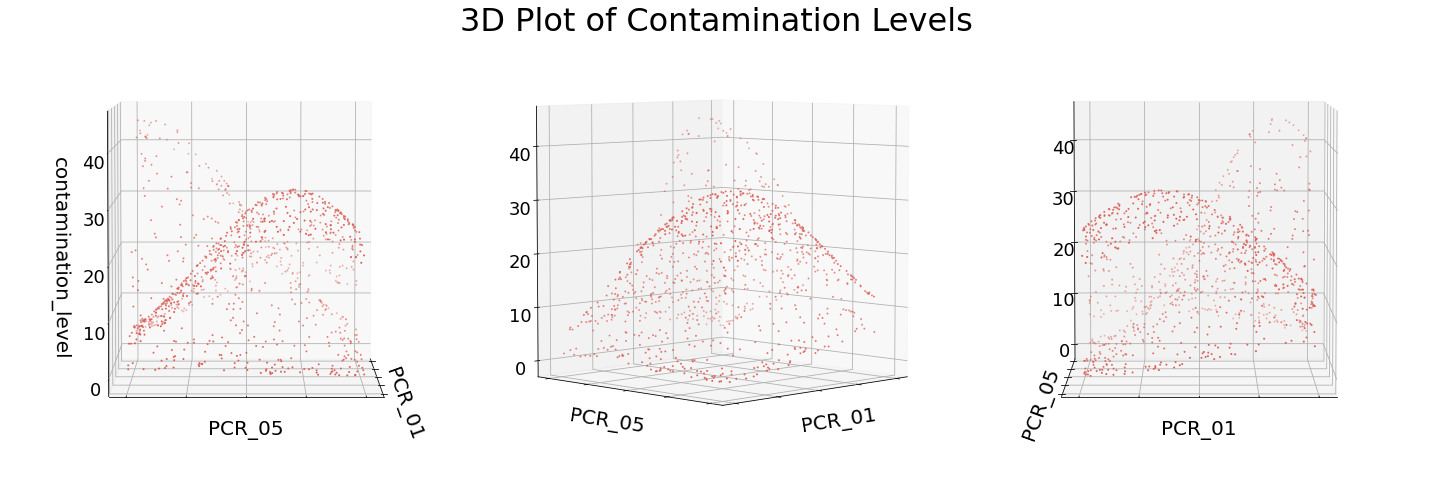

In [70]:
plot3d(train_mod, colX="PCR_01", colY="PCR_05", colZ="contamination_level", title="3D Plot of Contamination Levels")

## Question 14

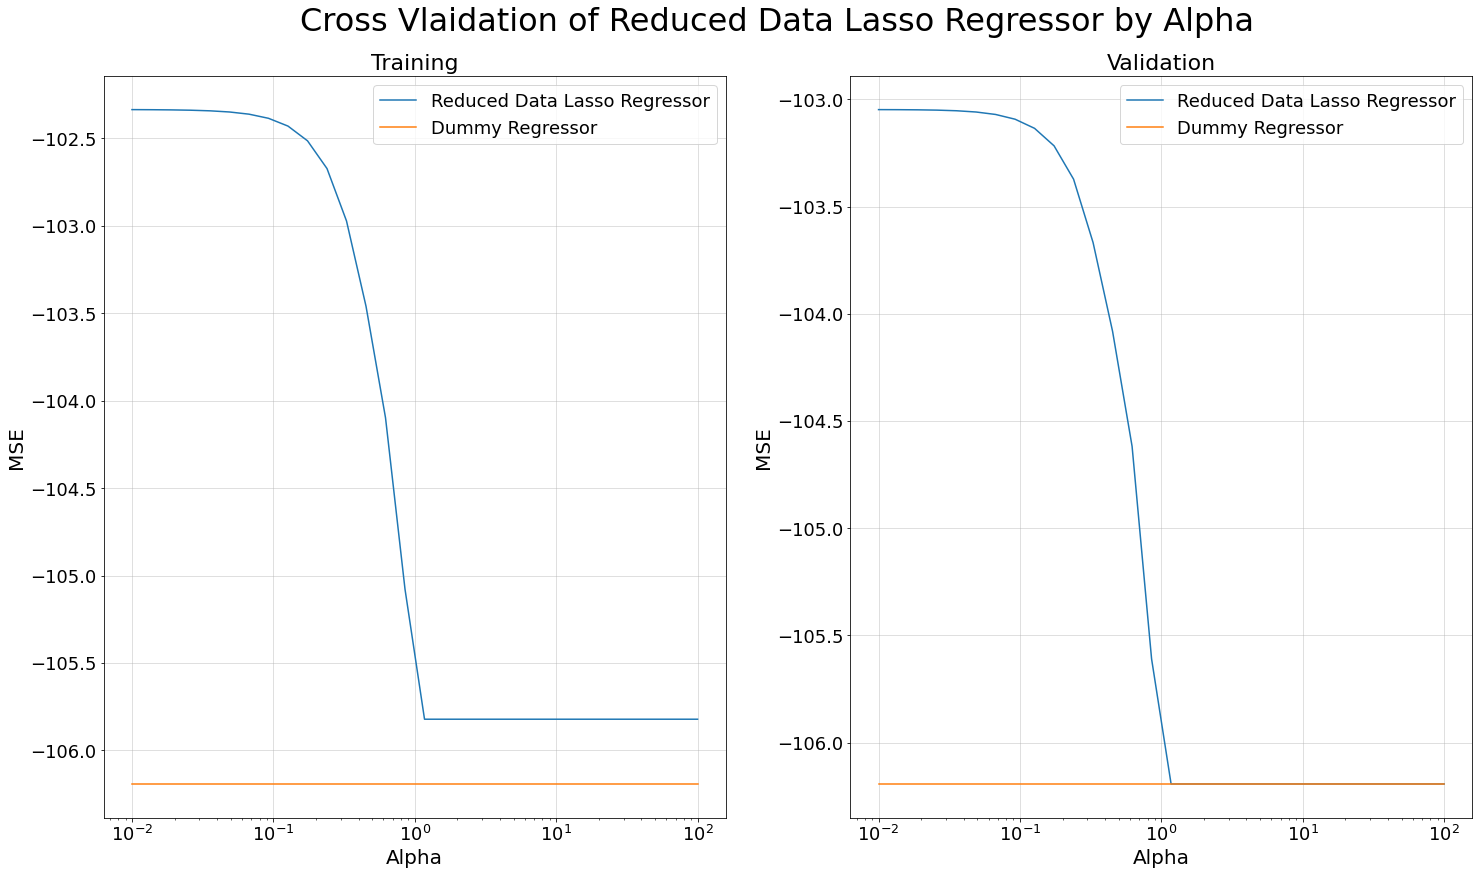

In [71]:
#@title Tune for regularization strength `alpha` and plot the results:
train_mod_X = train_mod[["PCR_01", "PCR_05"]]
train_mod_y = train_mod["contamination_level"]

alpha_list = np.logspace(-2, 2, 30)
mean_train_score = []
mean_val_score = []

for alpha in alpha_list:
    red_data_lasso = Lasso(alpha = alpha, fit_intercept=True)
    cv_red_data_lasso_scores = cross_validate(red_data_lasso,
                                              train_mod_X,
                                              train_mod_y,
                                              scoring="neg_mean_squared_error",
                                              cv=5, 
                                              return_train_score=True)
    mean_train_score = np.append(mean_train_score, np.mean(cv_red_data_lasso_scores['train_score']))
    mean_val_score = np.append(mean_val_score, np.mean(cv_red_data_lasso_scores['test_score']))

dummy_mean_train = np.full(shape=mean_train_score.shape, fill_value = dummy_redr_train_loss)
dummy_mean_val = np.full(shape=mean_val_score.shape, fill_value = dummy_redr_val_loss)

semilogx_plot(alpha_list, mean_train_score, mean_val_score, dummy_mean_train, dummy_mean_val, "Alpha", "Reduced Data Lasso Regressor")

In [72]:
#@title Get optimal `alpha` and its score:

opt_alpha_idx = np.argmax(mean_val_score)
opt_alpha = alpha_list[opt_alpha_idx]
print(f"The optimal alpha for the modified data set is {opt_alpha}.")
print(f"It achieved a training loss of {mean_train_score[opt_alpha_idx]} and a validation loss of {mean_val_score[opt_alpha_idx]}")

The optimal alpha for the modified data set is 0.01.
It achieved a training loss of -102.33486581542716 and a validation loss of -103.04806095022465


In [73]:
#@title Retrain the Lasso regressor on the entire training set with `optimal alpha`:

lasso_mod = Lasso(alpha = opt_alpha, fit_intercept=True)
lasso_mod.fit(train_mod_X, train_mod_y)

Lasso(alpha=0.01)

## Question 15

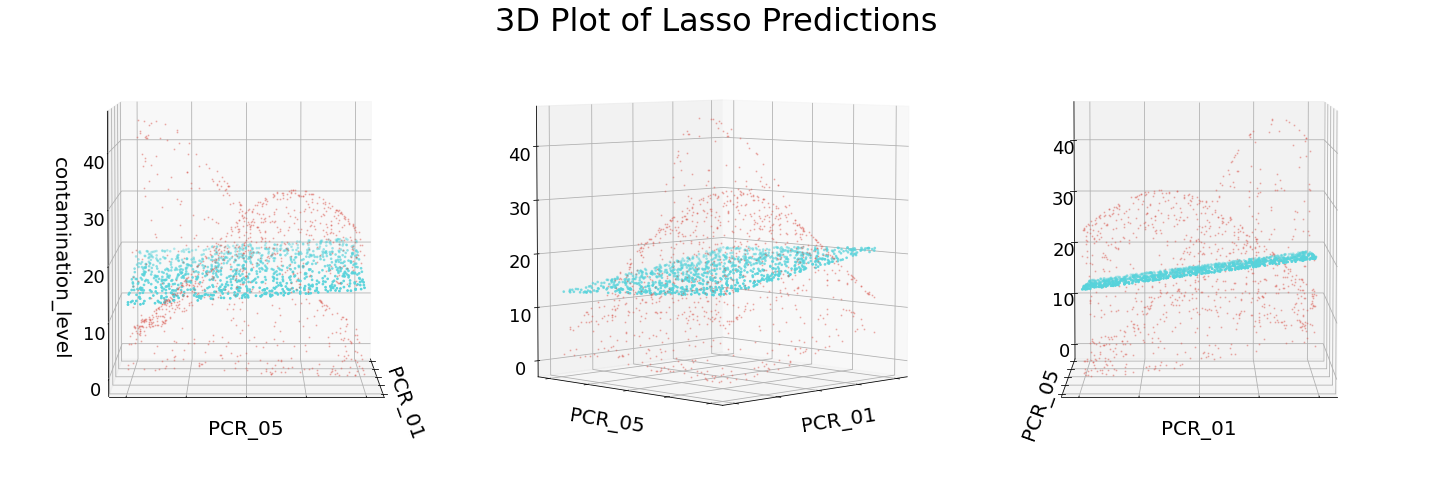

In [74]:
#@title Predict and visualize the model above:

pred = lasso_mod.predict(train_mod_X)
plot3d(train_mod, colX="PCR_01", colY="PCR_05", colZ="contamination_level", title="3D Plot of Lasso Predictions", predictions=pred)

## Question 16

In [75]:
#@title Create a `Pipeline` object to improve Lasso Regressor with feature mapping:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

poly_reg = Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=2)),
                           ('normalization', StandardScaler()),
                           ('Lasso', Lasso(alpha=opt_alpha, fit_intercept=True))])

## Question 17

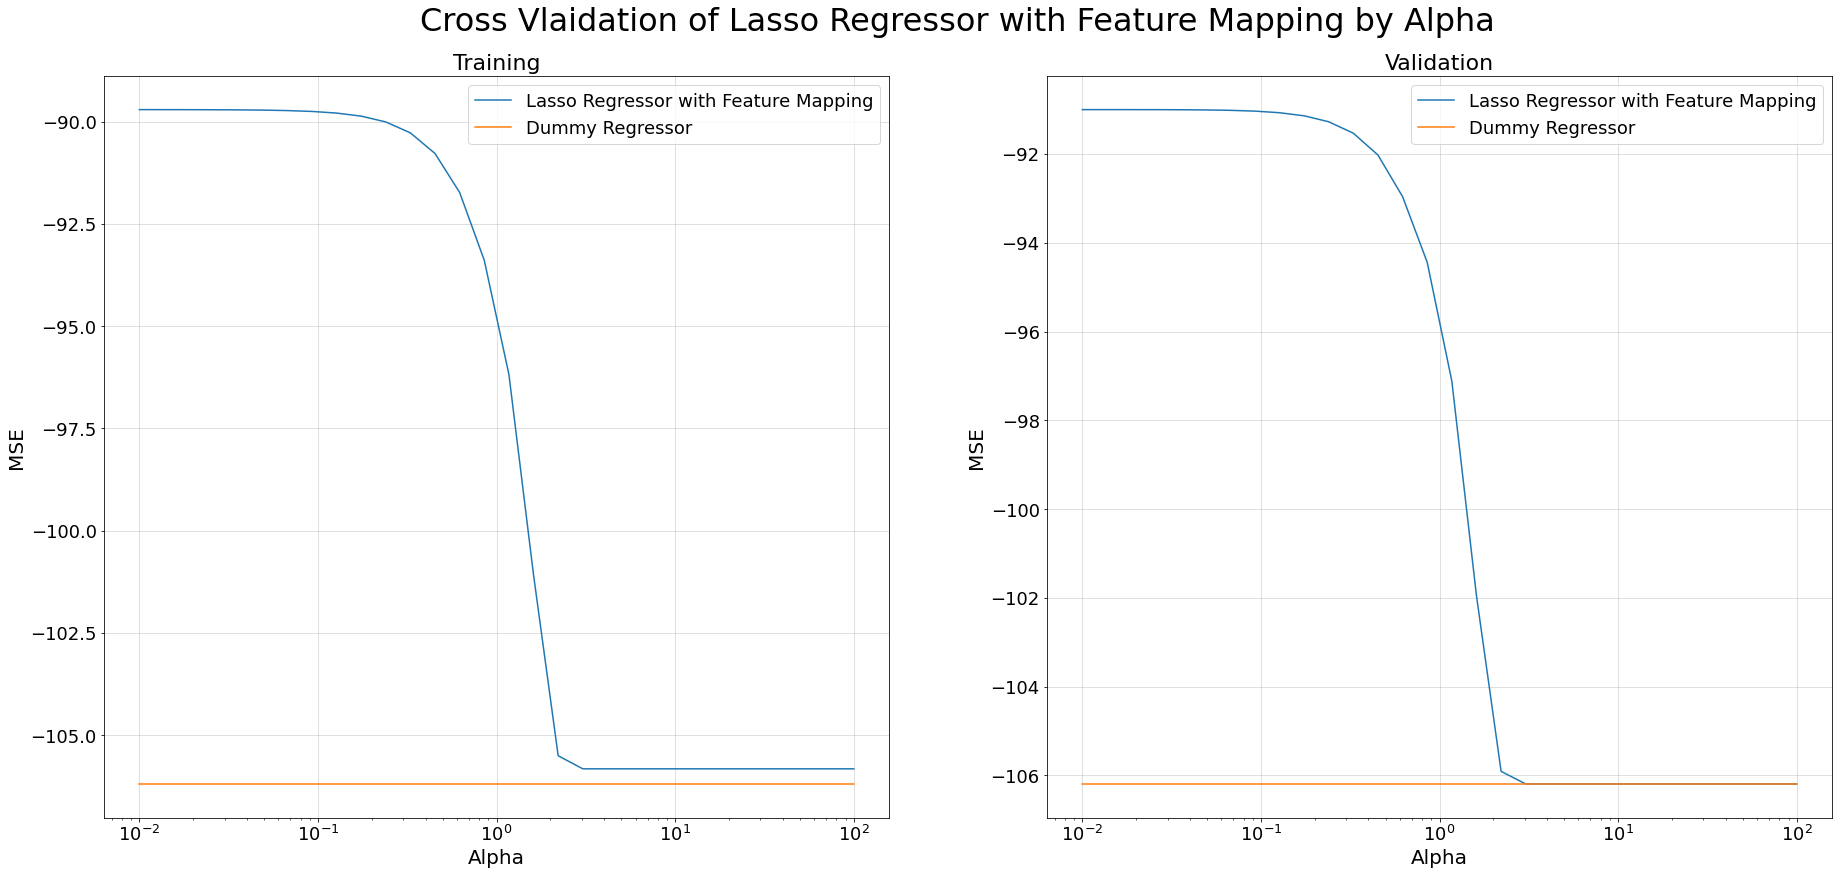

In [76]:
#@title Tune the regularization strength of a Lasso regressor with the polynomial mapping using CV:

alpha_list = np.logspace(-2, 2, 30)
mean_train_score = []
mean_val_score = []

for alpha in alpha_list:
    cur_pipe = Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=2)),
                               ('normalization', StandardScaler()),
                               ('Lasso', Lasso(alpha=alpha, fit_intercept=True))])
    cv_poly_fit_lasso_scores = cross_validate(cur_pipe,
                                              train_mod_X,
                                              train_mod_y,
                                              scoring="neg_mean_squared_error",
                                              cv=5,
                                              return_train_score=True)
    mean_train_score = np.append(mean_train_score, np.mean(cv_poly_fit_lasso_scores['train_score']))
    mean_val_score = np.append(mean_val_score, np.mean(cv_poly_fit_lasso_scores['test_score']))

dummy_mean_train = np.full(shape=mean_train_score.shape, fill_value = dummy_redr_train_loss)
dummy_mean_val = np.full(shape=mean_val_score.shape, fill_value = dummy_redr_val_loss)


semilogx_plot(alpha_list,
              mean_train_score,
              mean_val_score,
              dummy_mean_train,
              dummy_mean_val,
              "Alpha",
              "Lasso Regressor with Feature Mapping",
              (25, 12));

In [77]:
#@title Get optimal `alpha` and its score:

opt_alpha_poly_idx = np.argmax(mean_val_score)
opt_alpha_poly = alpha_list[opt_alpha_idx]
print(f"The optimal alpha for the modified data set is {opt_alpha_poly}")
print(f"It achieved a training loss of {mean_train_score[opt_alpha_idx]} and a validation loss of {mean_val_score[opt_alpha_idx]}")

The optimal alpha for the modified data set is 0.01
It achieved a training loss of -89.7077878930491 and a validation loss of -91.0000679755324


In [78]:
#@title Retrain the Lasso regressor on the entire training set with optimal alpha:


# @TODO: Why do we need that...

poly_lasso_regressor = Lasso(alpha=opt_alpha_poly, fit_intercept=True)
lasso_regressor.fit(train_X, train_y);

## Question 18

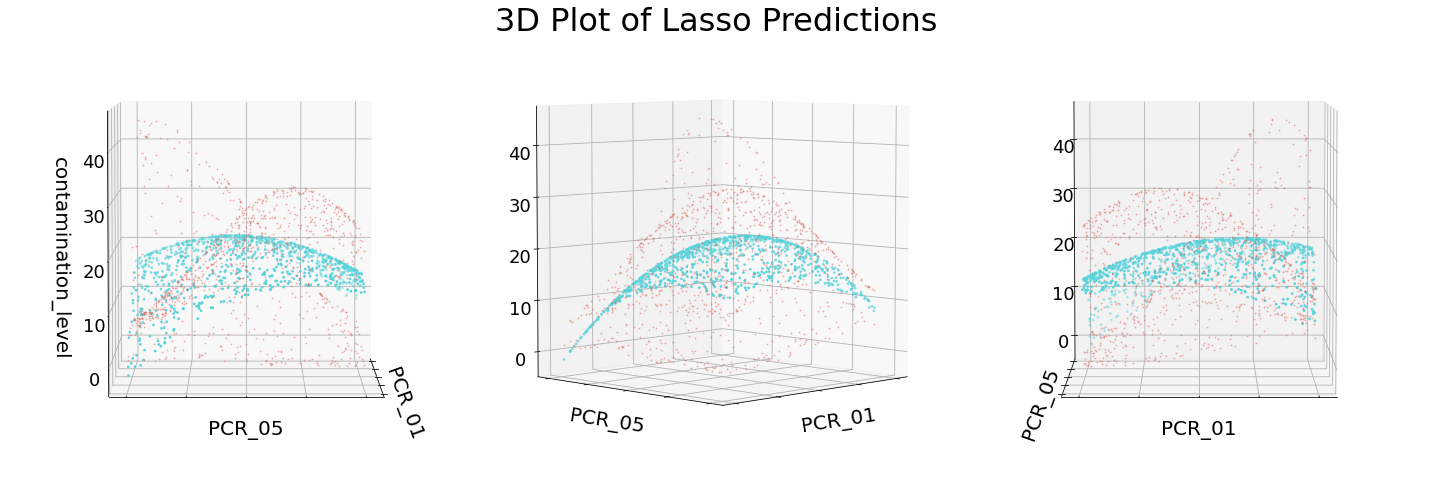

In [79]:
poly_reg = Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=2)),
                           ('normalization', StandardScaler()),
                           ('Lasso', Lasso(alpha=opt_alpha_poly, fit_intercept=True))])

poly_reg.fit(train_mod_X, train_mod_y)
pred = poly_reg.predict(train_mod_X)

plot3d(train_mod, 
       colX="PCR_01", 
       colY="PCR_05", 
       colZ="contamination_level", 
       title="3D Plot of Lasso Predictions", 
       predictions=pred);

# Section 5: RandomForest fitting of the CovidScore

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.compose import ColumnTransformer

train_cpy = train.copy()
train_cpy_X = train_cpy.loc[:, train_cpy.columns != "contamination_level"]
train_cpy_y = train_cpy["contamination_level"]

test_cpy = test.copy()
test_cpy_X = test_cpy.loc[:, test_cpy.columns != "contamination_level"]
test_cpy_y = test_cpy["contamination_level"]

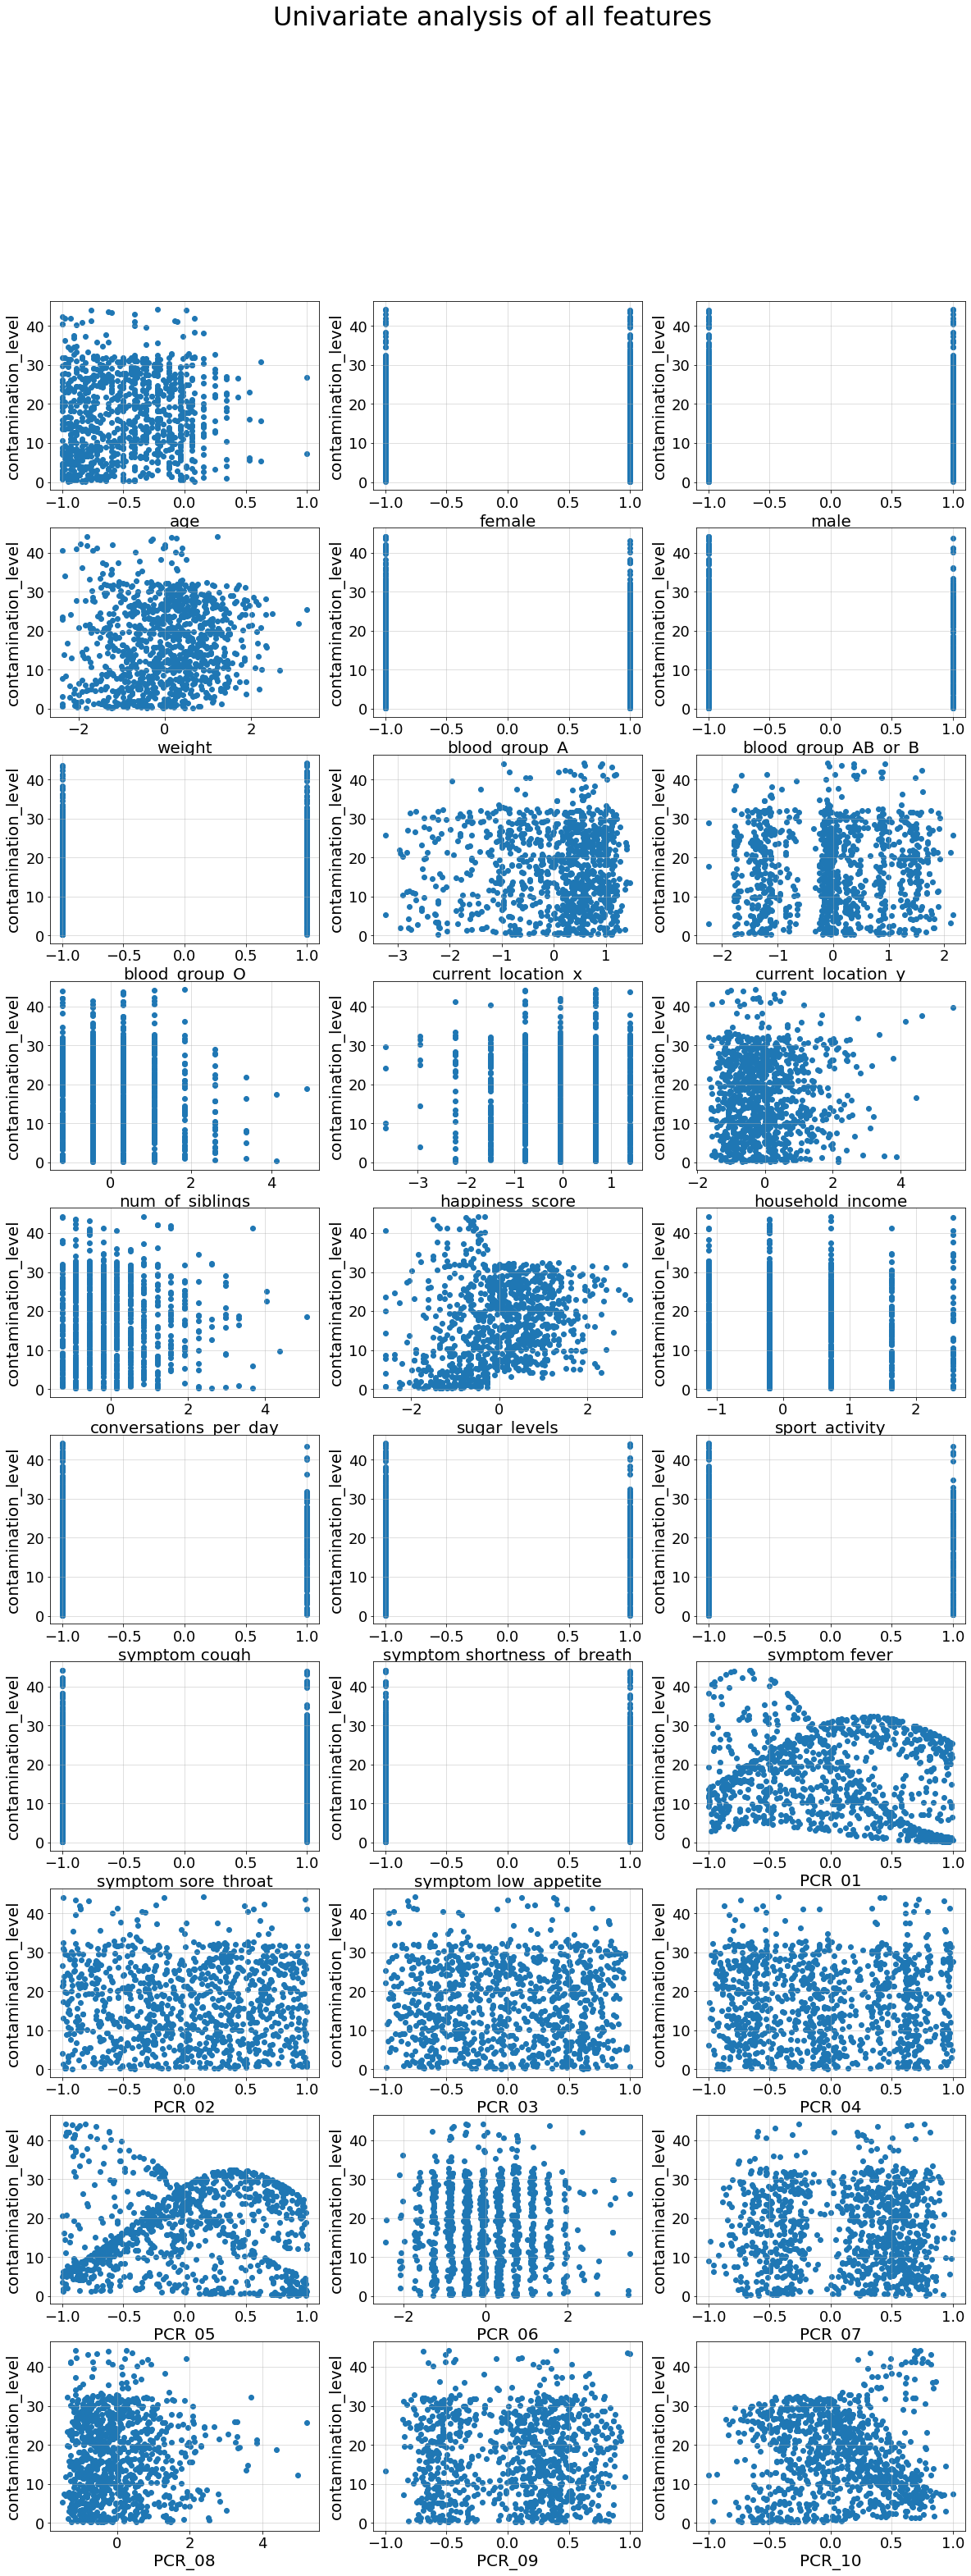

In [84]:
# Here we shall do a univariate analysis of all fetures, with that we shall decide which features shoul dbe transformed by which feature mapping

columns = train_X.columns.values

fig, axs = plt.subplots(10, 3, figsize=(20, 50))
plt.suptitle(f"Univariate analysis of all features", fontsize=32)
#plt.tight_layout()
#fig.subplots_adjust(hspace=0.5, top=0.9)
axs = np.ravel(axs)

for i, feat in enumerate(columns):
    axs[i].scatter(x=train_X[feat], y=train_y)
    axs[i].grid(alpha = 0.5)
    axs[i].set_xlabel(feat)
    axs[i].set_ylabel('contamination_level')


In [82]:
#@title Discover which features we want for RBF mapping and which for polynomial mapping:


#gamma_list = np.logspace(-3, 3, 49)
gamma_list = np.logspace(-2, 2, 30)

mean_train_score = []
mean_val_score = []

RBF_feats = ['PCR_01', 'PCR_01']
poly_2_feats = ['PCR_01', 'PCR_05', 'suger_levels']
poly_3_feats = []

for gamma in gamma_list:
    # feture mapping:
    col_trans = ColumnTransformer(
        [("RBF_feature_mapping", RBFSampler(gamma=gamma, random_state=random_state), RBF_feats),
        ("Polynomial_2nd_mapping", PolynomialFeatures(degree=2), poly_2_feats),
        ("Polynomial_3rd_mapping", PolynomialFeatures(degree=3), poly_3_feats)])
    
    # create the pipe:
    cur_pipe = Pipeline(steps=[('normalization', StandardScaler()),
                               ('feature_mapping', col_trans),
                               ('RandomForests', RandomForestRegressor())])
    #do Cross-Validation:
    cv_random_forests_scores = cross_validate(cur_pipe,
                                              train_cpy_X,
                                              train_cpy_y,
                                              scoring="neg_mean_squared_error",
                                              cv=5,
                                              return_train_score=True)
    # get scores of that iteration:
    mean_train_score = np.append(mean_train_score, np.mean(cv_random_forests_scores['train_score']))
    mean_val_score = np.append(mean_val_score, np.mean(cv_random_forests_scores['test_score']))



SyntaxError: ignored

In [ ]:
dummy_mean_train = np.full(shape=mean_train_score.shape, fill_value = dummy_redr_train_loss)
dummy_mean_val = np.full(shape=mean_val_score.shape, fill_value = dummy_redr_val_loss)

semilogx_plot(gamma_list,
              mean_train_score,
              mean_val_score,
              dummy_mean_train,
              dummy_mean_val,
              "Gamma",
              "Random Forests with Feature Mapping",
              (25, 12));
